In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_fp = pd.read_csv("data/fp_data_final.csv", index_col=0)
df_gk = pd.read_csv("data/gk_data_final.csv", index_col=0)
pd.set_option('display.max_columns', None)

In [3]:
# set random seed for all algos
rseed = 42

In [4]:
# suppress scientific notation
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

### Prepare datasets for prediction | general

In [5]:
# drop irrelevant rows

df_fp = df_fp.drop(["player_name","long_name","year_of_birth","height_cm","weight_kg","nationality","club"],axis=1)

df_gk = df_gk.drop(["player_name","long_name","year_of_birth","height_cm","weight_kg","nationality","club"],axis=1)

### Vorgehensweise
1. Für finalen Test --> Test-Set wegpacken
2. Mit train_set train-test-split und predicten
3. Final mit test_set_final predicten

In [6]:
# 1. put final test set aside

# fieldplayers
train_set_fp = df_fp.sample(frac=0.80, random_state=rseed)
y_final_fp = df_fp.drop(train_set_fp.index)
y_final_fp = y_final_fp["market_value_in_euro"]

# goal keepers
train_set_gk = df_gk.sample(frac=0.80, random_state=rseed)
y_final_gk = df_gk.drop(train_set_gk.index)
y_final_gk = y_final_gk["market_value_in_euro"]

print("Fieldplayers: ")
print(train_set_fp.shape)
print(y_final_fp.shape)
print("-----------------------")
print("Goalkeepers: ")
print(train_set_gk.shape)
print(y_final_gk.shape)

Fieldplayers: 
(8598, 54)
(2149,)
-----------------------
Goalkeepers: 
(1110, 37)
(277,)


# Define Pipelines

## Identify best models 

Regressors to be used:
1. Linear Regression
6. Stochastic Gradient Descent
7. Decision Trees
8. Random Forest
9. AdaBoost
10. Gradient Tree Boosting
11. XGBoost


In [26]:
def model_selection (train_set):

    ###################################
    # 2.1. train-test-split with remaining 80% of data
    ###################################

    from sklearn.model_selection import train_test_split

    X = train_set.drop(["market_value_in_euro"],axis=1)

    y = train_set["market_value_in_euro"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rseed)

    ###################################
    # 2.2. Build preprocessing pipeline with
    # - standard scaler
    # - onehotencoder
    ###################################

    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler, OneHotEncoder

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    ###################################
    # 2.3. Apply column transformer
    ###################################

    from sklearn.compose import ColumnTransformer

    numeric_features = train_set.select_dtypes(include=['int64', 'float64']).drop(["market_value_in_euro"],axis=1).columns
    categorical_features = train_set.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    ###################################
    # 2.4. Fit algorithms
    ###################################

    from sklearn import linear_model
    from sklearn import svm
    from sklearn import tree
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import AdaBoostRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb
    

    models = []
    models.append(("LR",linear_model.LinearRegression()))
    models.append(("SGD",linear_model.SGDRegressor(random_state=rseed)))
    models.append(("DT",tree.DecisionTreeRegressor(random_state=rseed)))
    models.append(("RF",RandomForestRegressor(random_state=rseed,n_jobs=-1)))
    models.append(("ADA",AdaBoostRegressor(random_state=rseed)))
    models.append(("GDB",GradientBoostingRegressor(random_state=rseed)))
    models.append(("XGB",xgb.XGBRegressor(random_state=rseed)))
    

    results = []
    names = []
    scoring = 'neg_root_mean_squared_error'
    
    for name,regressor in models:
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', regressor)])
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
    
        ###################################
        # 2.5. Calculate comparison metric (MRSE) and visualize comparison
        ###################################

        from sklearn.metrics import mean_squared_error
        
        import math
        from math import sqrt
        
        from sklearn import model_selection
        from sklearn.model_selection import cross_val_score

        
        
        kfold = model_selection.KFold(n_splits=5, random_state=rseed, shuffle=True)
        cv_results = abs(model_selection.cross_val_score(pipe, X, y, cv=kfold, scoring=scoring))
        cv_mean = math.ceil(cv_results.mean())
        cv_std = math.ceil(cv_results.std())
        results.append(cv_results)
        names.append(name)
        print(f"{name}: ", f"{cv_mean:0,}", f"({cv_std:0,})")

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

LR:  2,518,939 (81,314)
SGD:  2,524,106 (81,601)
DT:  2,696,631 (136,046)
RF:  1,934,319 (90,223)
ADA:  3,953,392 (205,402)
GDB:  1,878,969 (121,475)
[18:00:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Fabian\Anaconda3\envs\nf\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Fabian\Anaconda3\envs\nf\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:00:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Fabian\Anaconda3\envs\nf\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:00:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Fabian\Anaconda3\envs\nf\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:00:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Fabian\Anaconda3\envs\nf\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:00:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Fabian\Anaconda3\envs\nf\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[18:00:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB:  1,858,716 (120,307)


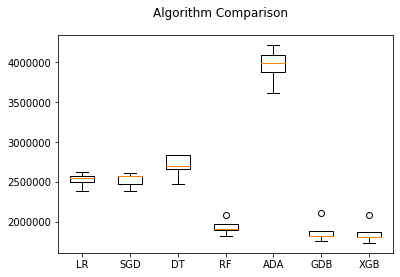

In [27]:
model_selection (train_set_fp)

###### --> best 3 algorithms are Random Forests, GDBoost and XGBoost

In [44]:
def best_algos_pipeline (train_set):

    ###################################
    # 2.1. train-test-split with remaining 80% of data
    ###################################

    from sklearn.model_selection import train_test_split

    X = train_set.drop(["market_value_in_euro"],axis=1)

    y = train_set["market_value_in_euro"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rseed)

    ###################################
    # 2.2. Build preprocessing pipeline with
    # - a scaler for numerical columns
    # - an encoder for categorical columns
    ###################################

    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler, OneHotEncoder

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    ###################################
    # 2.3. Apply column transformer
    ###################################

    from sklearn.compose import ColumnTransformer

    numeric_features = train_set.select_dtypes(include=['int64', 'float64']).drop(["market_value_in_euro"],axis=1).columns
    categorical_features = train_set.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    ###################################
    # 2.4. Fit algorithms
    ###################################

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb
    

    models = []
    models.append(("Random Forest",RandomForestRegressor(random_state=rseed,n_jobs=-1)))
    models.append(("Gradient Boost",GradientBoostingRegressor(random_state=rseed)))
    models.append(("XGBoost",xgb.XGBRegressor(random_state=rseed)))
    
    param_grid = {
        'regressor__n_estimators': [200, 500],
        'regressor__max_features': ['auto', 'sqrt', 'log2'],
        'regressor__max_depth' : [4,5,6,7,8],}

    
    for name,regressor in models:
        pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', regressor)])
        

        
        from sklearn.model_selection import GridSearchCV
        
        CV = GridSearchCV(pipe, param_grid, n_jobs= 1)
        CV.fit(X_train, y_train)
        print(CV.best_params_)    
        print(CV.best_score_)
        
        y_pred = CV.predict(X_test)
    
        ###################################
        # 2.5. Calculate following metrics for each model with simple train-test-split and with cv
        # a. MSE
        # b. MRSE
        # c. MAE
        # d. R²
        # e. Adjusted R²
        ###################################

        from sklearn.metrics import mean_squared_error
        from sklearn.metrics import mean_absolute_error
        from sklearn.metrics import r2_score
        
        import math
        from math import sqrt
        
        from sklearn import model_selection
        from sklearn.model_selection import cross_val_score
        
        
        kfold = model_selection.KFold(n_splits=5, random_state=rseed, shuffle=True)
        
        # a
        mse = math.ceil(mean_squared_error(y_test, y_pred))
        cv_mse = cross_val_score(CV, X, y, cv=kfold, scoring="neg_mean_squared_error",n_jobs=-1)
        cv_mse_mean = math.ceil(abs(cv_mse.mean()))
       
        # b
        mrse = math.ceil(sqrt(mse))
        cv_mrse = cross_val_score(CV, X, y, cv=kfold, scoring="neg_root_mean_squared_error",n_jobs=-1)
        cv_mrse_mean = math.ceil(abs(cv_mrse.mean()))
        
        # c
        mae = math.ceil(mean_absolute_error(y_test, y_pred))
        cv_mae = cross_val_score(CV, X, y, cv=kfold, scoring="neg_mean_absolute_error",n_jobs=-1)
        cv_mae_mean = math.ceil(abs(cv_mae.mean()))
        
        # d
        r_squared = round(r2_score(y_test, y_pred),3)
        cv_r_squared = cross_val_score(CV, X, y, cv=kfold, scoring="r2",n_jobs=-1)
        cv_r_squared_mean = round((cv_r_squared.mean()),3)
        
        # e
        n = train_set.shape[0]
        p = len(train_set.columns)
        adjusted_r_squared = round((1-(1-r_squared)*(n-1)/(n-p-1)),3)
        cv_adjusted_r_squared = round((1-(1-cv_r_squared_mean)*(n-1)/(n-p-1)),3)
        
        ###################################
        # 2.6. Print results
        ###################################
      
          
        from prettytable import PrettyTable
        ptable = PrettyTable()

        ptable.field_names = ["Metric", "Score on test set", "Score on test set with 5 k-fold CV "]
        ptable.add_row(["MSE",f"{mse:0,}",f"{cv_mse_mean:0,}"])
        ptable.add_row(["MRSE",f"{mrse:0,}",f"{cv_mrse_mean:0,}"])
        ptable.add_row(["MAE",f"{mae:0,}",f"{cv_mae_mean:0,}"])
        ptable.add_row(["r_squared",r_squared,cv_r_squared_mean])
        ptable.add_row(["adjusted_r_squared",adjusted_r_squared,cv_adjusted_r_squared])
        
        print("----------------------------------------------------------------------------------------------------------")
        print("\033[1m",name,"\033[0m")
        print("----------------------------------------------------------------------------------------------------------")
        print (ptable)
        ###################################
        # 2.5. Print results
        ###################################
        from yellowbrick.regressor import residuals_plot
        from yellowbrick.datasets import load_concrete

        # Visualization of residuals
        viz = residuals_plot(CV, X_train, y_train, X_test, y_test)

{'regressor__max_depth': 8, 'regressor__max_features': 'auto', 'regressor__n_estimators': 500}
0.7155999481955299
----------------------------------------------------------------------------------------------------------
 Random Forest 
----------------------------------------------------------------------------------------------------------
+--------------------+-------------------+-------------------------------------+
|       Metric       | Score on test set | Score on test set with 5 k-fold CV  |
+--------------------+-------------------+-------------------------------------+
|        MSE         | 3,862,136,663,177 |          3,763,698,877,407          |
|        MRSE        |     1,965,232     |              1,937,930              |
|        MAE         |      913,363      |               902,914               |
|     r_squared      |       0.704       |                0.724                |
| adjusted_r_squared |       0.702       |                0.722                |
+-------

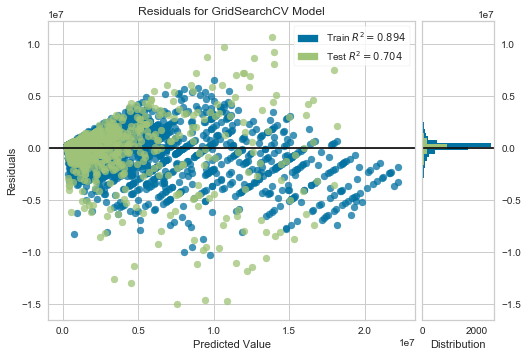

KeyboardInterrupt: 

In [45]:
best_algos_pipeline (train_set_fp)

# todos

- different scalers
- different encoder?
- gridsearch
- features importances --> feature engineering and adjustments to dataset --> recursive feature elimination